EDA of new simulation to validate expected relationships given new simulation changes

# Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# AFM imports
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

from pyafm.util import invlogit
from pyafm.custom_logistic import CustomLogistic

In [12]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [13]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
db_params['port'] = 27018
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-05763f36-fbb6-4358-b1be-87fa8d79ee57
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': 27018, 'name': 'motivsim', 'user': '', 'pswd': ''}


In [14]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, steps, has 56625 documents
INFO:log_db.mongo:collection name, problems, has 13535 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, kcs, has 488 documents
INFO:log_db.mongo:collection name, students, has 20 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, simbatches, has 1 documents
INFO:log_db.mongo:collection name, tutor_events, has 28741 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, sessions, has 200 documents
INFO:log_db.mongo:collection name, decisions, has 33541 documents
INFO:log_db.mongo:collection name, actions, has 33541 documents
INFO:log_db.mongo:collection name, sections, has 75 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 20 documents


In [15]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Clearing database before starting new simulation


# 1. Simulating learners

In [16]:
num_students = 20
num_sessions = 20

In [17]:
sim_helper = SimHelper(db)

In [18]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

#     mod = round(len(students) / 10)
    mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [19]:
new_curric = None
new_domain = None

In [20]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [21]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Self Efficacy Diligent students

In [22]:
sim_batch_desc = "Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se}}

In [23]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 590 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, b8a3cdcc-86ea-433e-aaee-1cbae2999dde, to db
INFO:log_db.curriculum_mapper:Writing 16603 problem to db
INFO:log_db.curriculum_mapper:Writing 69700 steps to db
INFO:analytics.session:Persisting 20 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #1
INFO:analytics.session:Simulating student #2
INFO:analytics.session:Simulating student #3
INFO:analytics.session:Simulating student #4
INFO:analytics.session:Simulating student #5
INFO:analytics.session:Simulating student #6
INFO:analytics.session:Simulating student #7
INFO:analytics.session:Simulating student #8
INFO:analytics.session:Simulating student #9
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simula

# Validation EDA

## Setup

In [24]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [25]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [26]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [27]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_step_accuracy(steps):
    steps['is_correct'] = steps['outcome'] == 'Correct'
    step_acc = steps.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x)).rename("step_accuracy")
    return step_acc
    

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [28]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [29]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)

    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
    

    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)

    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()

    # Fit line for each student tendency to request hint
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac, 
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       ot_err, g_err], axis=1)

    return stats


In [30]:
def afm_stu_intercept(kcs, opps, actuals, stu, student_label, item_label, nfolds=3,
        seed=None):
    """
    Executes AFM on the provided data and returns model fits and parameter
    estimates
    """
    sv = DictVectorizer()
    qv = DictVectorizer()
    ov = DictVectorizer()

    S = sv.fit_transform(stu)
    Q = qv.fit_transform(kcs)
    O = ov.fit_transform(opps)

    X = hstack((S, Q, O))
    y = np.array(actuals)

    l2 = [1.0 for i in range(S.shape[1])]
    l2 += [0.0 for i in range(Q.shape[1])]
    l2 += [0.0 for i in range(O.shape[1])]

    bounds = [(None, None) for i in range(S.shape[1])]
    bounds += [(None, None) for i in range(Q.shape[1])]
    bounds += [(0, None) for i in range(O.shape[1])]

    X = X.toarray()
    X2 = Q.toarray()

    model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
    model.fit(X, y)

    coef_s = model.coef_[0:S.shape[1]]
    coef_s = [[k, v, invlogit(v)]
              for k, v in sv.inverse_transform([coef_s])[0].items()]

    return coef_s

In [31]:
def get_afm_steps(sids):
    tx = get_tx(sids)
    
    # Rollup steps
    #Step outcome
    step_outcomes = tx.sort_values('time').groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['outcome'].first()
    # Get time stamp for last tx
    time = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])
    steps = pd.concat([step_outcomes, time], axis=1)
    # Get kc
    steps = pd.merge(steps, tx.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    return steps

def run_afm(steps):
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    
    nfolds = 3
    seed = None
#     scores, kc_vals, coef_s = afm(kcs, opps, y, stu,
#                                   student_label, item_label, nfolds, seed)
    coef_s = afm_stu_intercept(kcs, opps, y, stu,
                                  student_label, item_label, nfolds, seed)
    stu_intercepts = pd.DataFrame(coef_s, columns=['stu_id', 'Intercept (logit)', 'Intercept (prob)'])
    stu_intercepts.index = stu_intercepts['stu_id']
    stu_intercepts.drop(columns=['stu_id'], inplace=True)
    return stu_intercepts

## Setup 2

In [53]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [54]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [55]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [88]:
def calc_stu_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)
    
    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
#     kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    exp_work_rate = calc_expected_work_rate(steps)

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean().unstack()
#     stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = get_action_counts(tx)
#     action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = total_tx_stats(tx)
#     tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = calc_stu_session_stats(tx)
#     ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats
    

## Calculate Stats

In [32]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [33]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Self-Efficacy students",
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: 9802c796-c0b1-407d-80cc-3b094b6c5e41
desc: Self-Efficacy students
INFO:analytics.session:recovered 20 student ids for batch Self-Efficacy students


In [89]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")

batch_size = 10
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"EDA of {len(sid)} students for batch, {desc}")
    
    
    def calc_all_stats(sids):
        d = calc_stu_stats(sids)
#         d.index.rename("stu_id", level=0, inplace=True)
#         d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

        logger.info(f"Completed calculating and merging stats: {stu_stats.shape}")
        return result
    
    args = [calc_all_stats, ids, batch_size]
    stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student stats: {stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 20 students for batch, Self-Efficacy students
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Calculated student stats: (20, 63)	Runtime: 36.227743 seconds


In [34]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9

logger.info("Starting calculation")

batch_size = 10
for desc in batch_descs:


    sid = sids[desc][0]
    logger.info(f"EDA of {len(sid)} students for batch, {desc}")

    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, batch_size, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [calc.get_action_counts, sid, batch_size]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, batch_size]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


    args = [session_calc.calc_stu_session_stats, sid, batch_size]
    ses_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student session stats: {ses_stats.shape}\tRuntime: {runtime} seconds")

    args = [calc_stats, sid, batch_size]
    dil_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated diligence stats: {dil_stats.shape}\tRuntime: {runtime} seconds")
    
#     args = [get_afm_steps, sid, batch_size]
#     afm_steps, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated Step rollup for afm: {afm_steps.shape}\tRuntime: {runtime} seconds")

# #    stu_afm = run_afm(afm_steps)
#     stu_afm, runtime = batch_calc.time_calc(run_afm, [afm_steps])
#     logger.info(f"Calculated afm intercepts: {stu_afm.shape}\tRuntime: {runtime} seconds")


#     stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
#                                  dil_stats, stu_afm], axis=1)


    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
                                 dil_stats], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 20 students for batch, Self-Efficacy students
INFO:analytics.session:Calculating for student set:	Self-Efficacy students
INFO:analytics.session:Calculated student params: (20, 20)	Runtime: 0.138623 seconds
INFO:analytics.session:Calculated student action stats: (20, 13)	Runtime: 2.503753 seconds
INFO:analytics.session:Calculated student activity stats: (20, 9)	Runtime: 1.986602 seconds
INFO:analytics.session:Calculated student session stats: (20, 5)	Runtime: 0.251389 seconds
INFO:analytics.session:Calculated diligence stats: (20, 21)	Runtime: 33.351645 seconds
INFO:analytics.session:Merged new stats together: (20, 68)


## Student Parameters EDA

### Correlation Matrix of Measures

In [90]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
cor_mat = {desc: pd.DataFrame(index=measures, columns = measures) for desc in batch_descs}
for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for m_i in measures:
        for m_j in measures:
            corr, pval = pearsonr(ss[m_i],ss[m_j])
            cor_mat[desc].loc[m_i, m_j] = corr
    logger.info(f"\n{cor_mat[desc]}")

        

INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish
pct class            1   -0.485532   -0.723531    -0.764825
Pct OffTask  -0.485532           1    0.194774     0.578085
start speed  -0.723531    0.194774           1     0.172635
early finish -0.764825    0.578085    0.172635            1


INFO:analytics.session:Self-Efficacy students


['diligence', 'cog_ability', 'dec_self_eff']


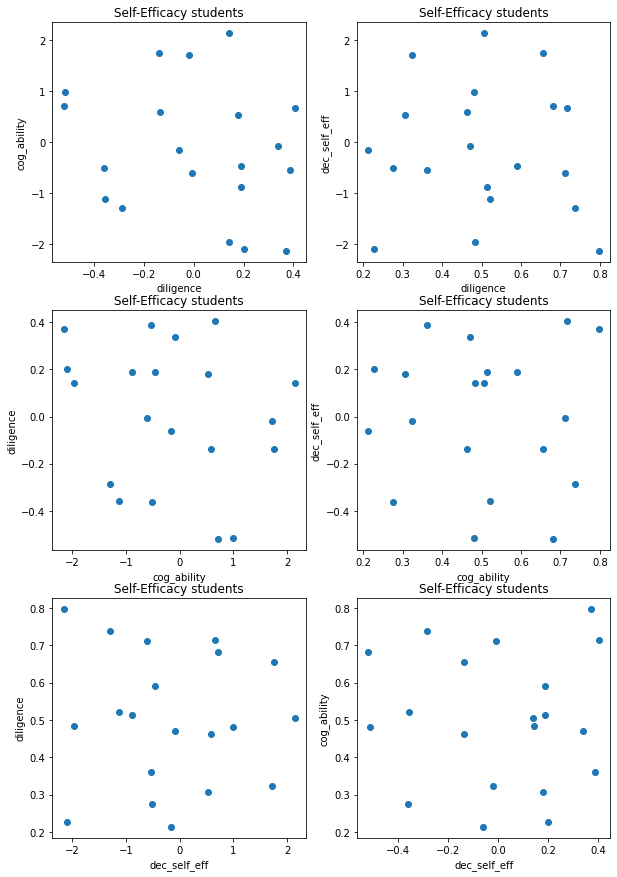

In [91]:


cols = ['diligence', 'cog_ability', 'dec_self_eff']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    i = 1
    avail_cols = [c for c in cols if c in sstats.columns.tolist()]
    print(avail_cols)
    l = len(avail_cols)
    plt.figure(figsize=(5*(l-1),5*(l)))
    logger.info(desc)
    for xcol in avail_cols:
        other_cols = [c for c in avail_cols if xcol != c]
        for ycol in other_cols:
            x = sstats[xcol]
            y = sstats[ycol]
            plt.subplot(len(avail_cols), len(other_cols), i)
            plt.scatter(y,x)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            plt.title(desc)    
            i += 1
    plt.show()
    

## Simulation Noise

### Session Opportunity

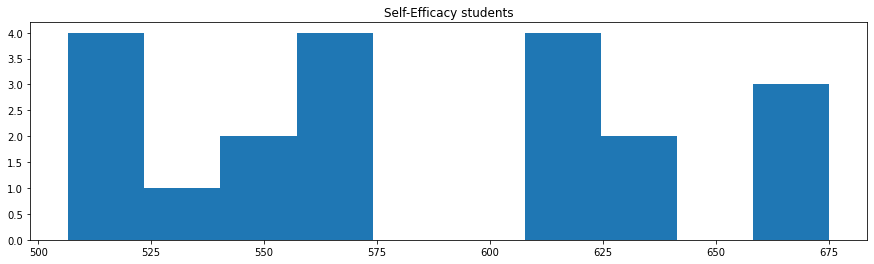

In [92]:
plt.figure(figsize=(15,4))
l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    col = 'total opportunity'
    plt.subplot(1,l, i+1)
    plt.hist(sstats['total opportunity'])
    plt.title(desc)    
plt.show()
    

### Detector error rates

In [93]:

l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    logger.info(f"************** {desc} ******************")
    d = stu_stats[desc]
    cols = [col for col in d.columns.tolist() if "offtask_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Offtask Error Rates: \nTP: {dpct['offtask_tp']}\tFP: {dpct['offtask_fp']}\tTN: {dpct['offtask_tn']}\tFN: {dpct['offtask_fn']}")
    cols = [col for col in d.columns.tolist() if "guess_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Guess Error Rates: \nTP: {dpct['guess_tp']}\tFP: {dpct['guess_fp']}\tTN: {dpct['guess_tn']}\tFN: {dpct['guess_fn']}")


INFO:analytics.session:************** Self-Efficacy students ******************


KeyError: 'offtask_tp'

### Work Rate - Tutor Policy Overpractice

INFO:analytics.session:************** Self-Efficacy students ******************


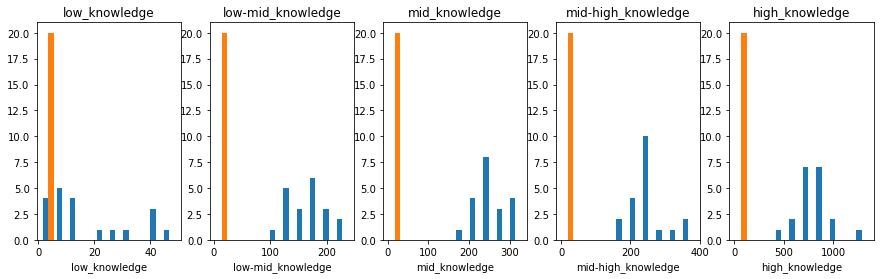

In [94]:

know_lvls = ['low_knowledge', 'low-mid_knowledge','mid_knowledge', 'mid-high_knowledge', 'high_knowledge']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(15,4))    
    for j, col in enumerate(know_lvls):
        plt.subplot(1,len(know_lvls), j+1)
        plt.hist(sstats[col])
        plt.xlabel(col)
        plt.title(col)

    plt.show()

## Diligence

### Help-seeking

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.3102288152853977	 pval = 0.1831304658318691
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = -0.10462895096897248	 pval = 0.6606655326324482
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = -0.028984971177206813	 pval = 0.9034509357819345
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8450774151229477	 pval = 2.7429017443313326e-06
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.5851142416617048	 pval = 0.006727017235928018


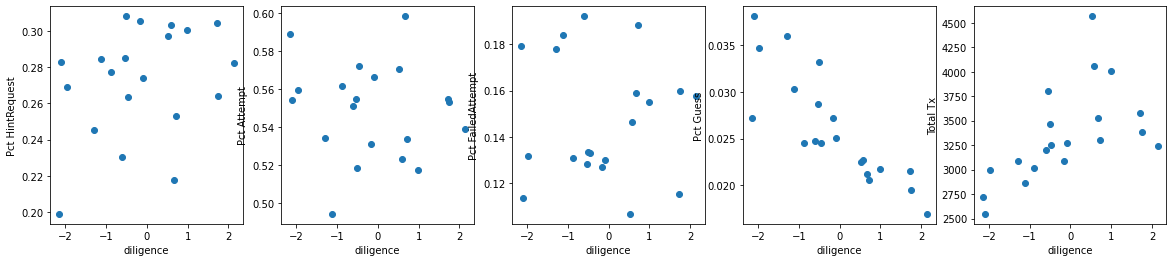

In [95]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Total Time

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.5382807521334814	 pval = 0.014349534186288855
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.7994033646862327	 pval = 2.3496790344777014e-05
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.6984567221271936	 pval = 0.0006140417864149766
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.4764217227030261	 pval = 0.03369886318317356
INFO:analytics.session:session length Correlation with diligence: 
R = 0.7743717348589229	 pval = 6.13374413111472e-05


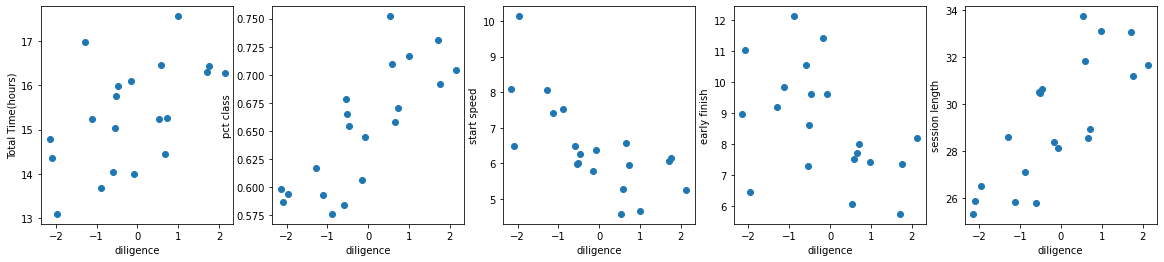

In [96]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.3642004338082919	 pval = 0.11441413297812275
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.5276037626655818	 pval = 0.016812039623754917
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8450774151229477	 pval = 2.7429017443313326e-06
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.2611266197477137	 pval = 0.2661238761453653
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.30578689679201726	 pval = 0.18981103098925728


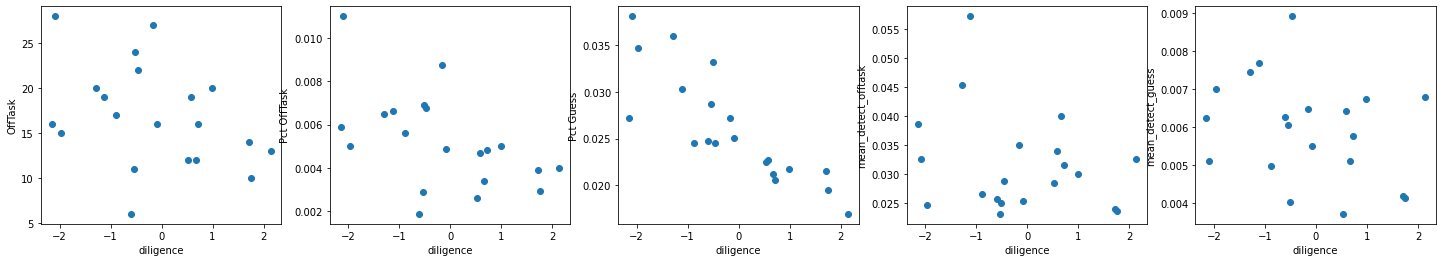

In [97]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(25,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Time-on-task

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.5382807521334814	 pval = 0.014349534186288855
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.5976990248005399	 pval = 0.005382911702551819
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.20342776678991925	 pval = 0.38966503122214036


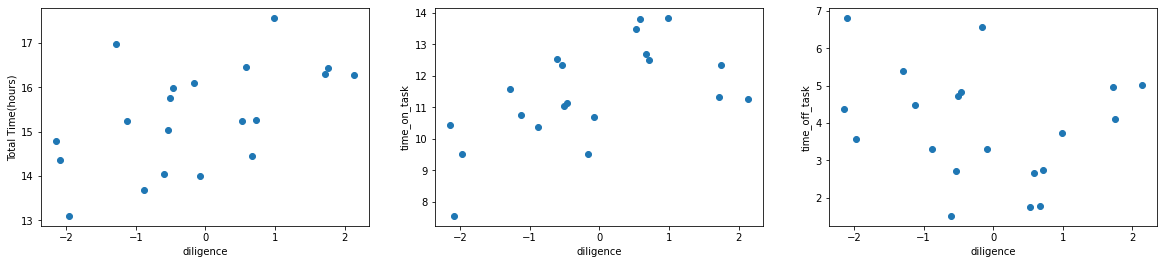

In [98]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = -0.21449624531926934	 pval = 0.3638125607688459
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = -0.08611177619689397	 pval = 0.7181154409616304
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.20877683993012344	 pval = 0.37704639833230824
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.5560254165013917	 pval = 0.010904919251545821
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.3122668704258357	 pval = 0.1801192200407459


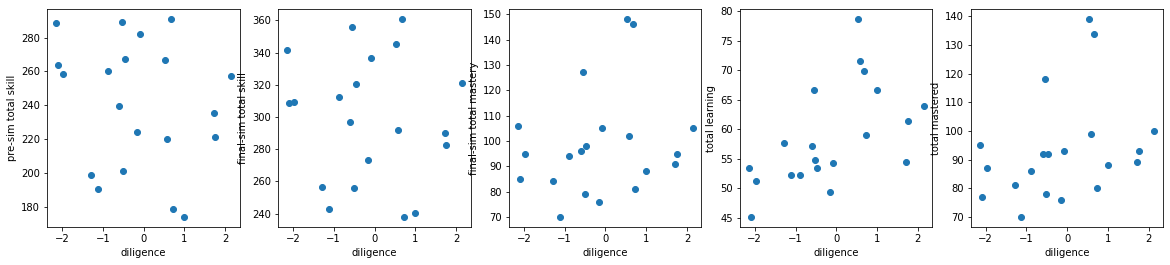

In [99]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Cog Ability

### Knowledge & Learning

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9955801313515195	 pval = 6.016065818316818e-20
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9659457355558743	 pval = 5.1696811990201086e-12
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.6652725679018281	 pval = 0.0013696753867695431
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.014711747417180399	 pval = 0.9509136000945327
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.5607431817455515	 pval = 0.010112260159956855


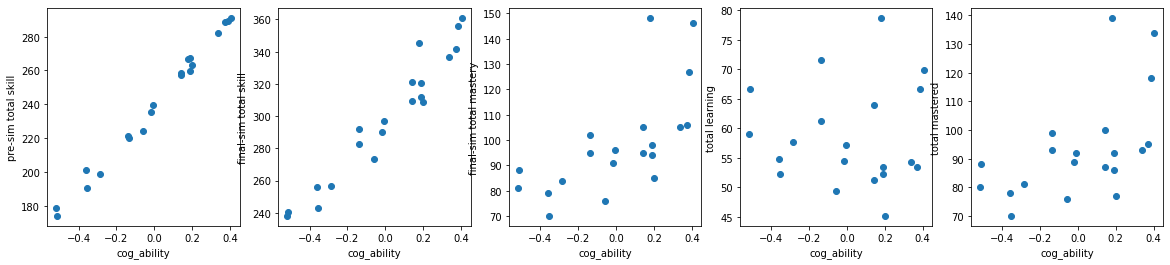

In [100]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Help-seeking

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.32817863414082293	 pval = 0.15776160269155332
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.8244178639377773	 pval = 7.813162273360803e-06
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.4017804357399538	 pval = 0.07909048310699571
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.003993345280404324	 pval = 0.9866689016564903
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = -0.11066560660355294	 pval = 0.6423069429633275


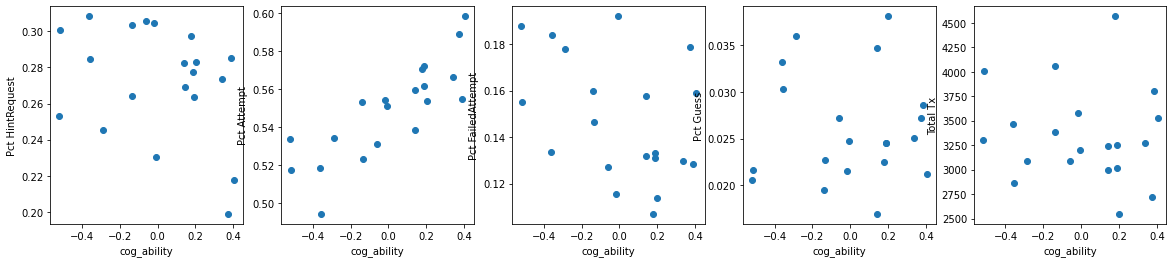

In [101]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Early Finish

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.19380906204683793	 pval = 0.41293601338294156
INFO:analytics.session:early finish Correlation with cog_ability: 
R = 0.06122628417323888	 pval = 0.7976251495062938
INFO:analytics.session:pct class Correlation with cog_ability: 
R = -0.15428598153756187	 pval = 0.5160367654860099
INFO:analytics.session:session length Correlation with cog_ability: 
R = -0.20968596120062066	 pval = 0.3749249135500304


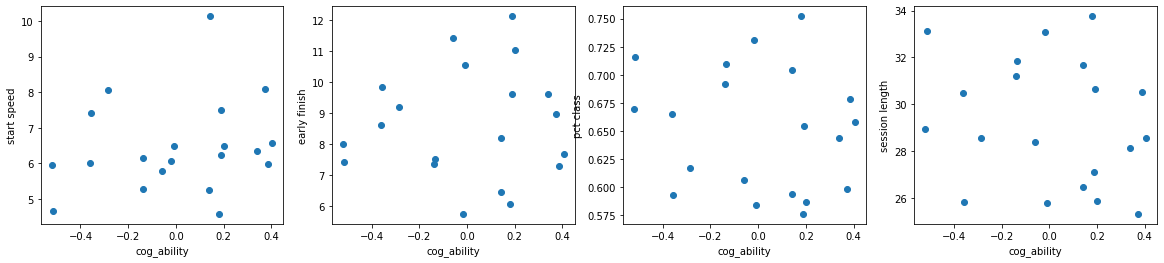

In [102]:

cols = ['start speed', 'early finish', 'pct class', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Work Rate

### Offtask

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.1275416378931465	 pval = 0.5920597189061537
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.14733697669969598	 pval = 0.5353354144945817
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.23147990771190208	 pval = 0.32611140808727185
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.2860532734881716	 pval = 0.22146281658506597


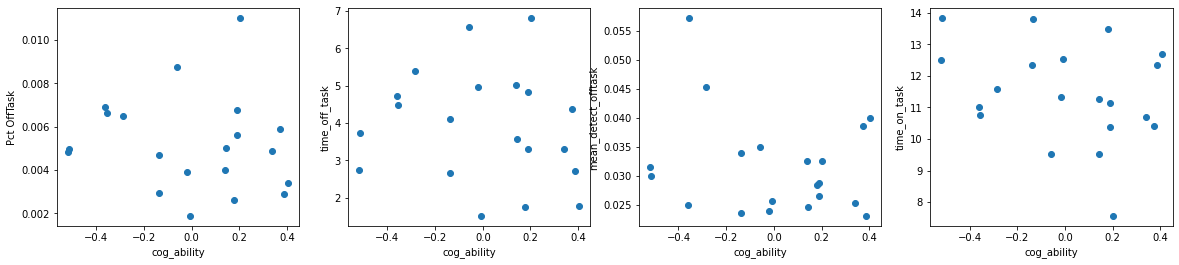

In [103]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Self-Efficacy

### Work Rate

### Offtask

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = -0.37091448594521303	 pval = 0.10739500093056674
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = -0.36359138223355986	 pval = 0.11506677806781694
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = 0.29205822647209206	 pval = 0.2114876933535883
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = 0.3067385556615484	 pval = 0.18836614533771803


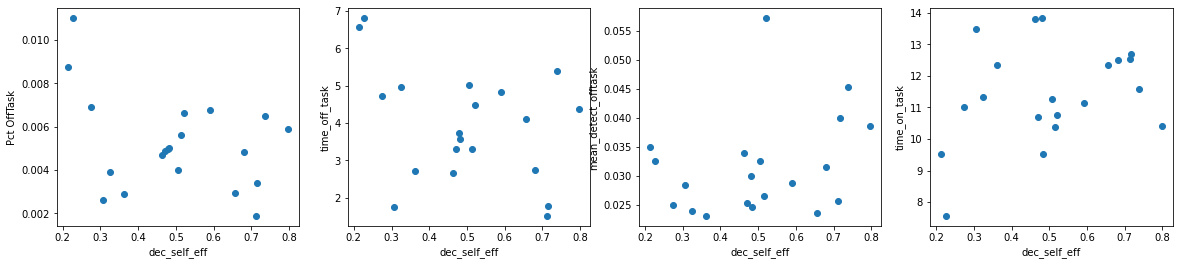

In [104]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']

for i,desc in enumerate(batch_descs):
        sstats = stu_stats[desc]  
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'dec_self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Help-seeking

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = -0.858861108206497	 pval = 1.2501366910349447e-06
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = 0.28240730104009404	 pval = 0.22766710088510259
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = 0.8102006258554373	 pval = 1.4897432179202529e-05
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = -0.24192893449734384	 pval = 0.30411828013404574
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = -0.22984877883912364	 pval = 0.329627655874654


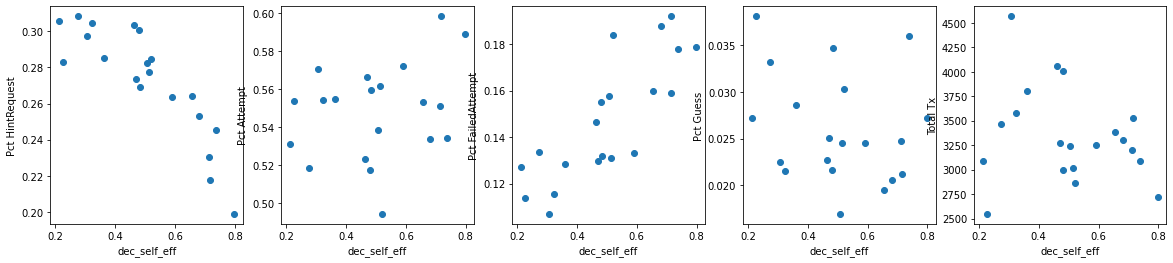

In [105]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = -0.0028791888777955008	 pval = 0.9903881254661917
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = 0.01800297109976972	 pval = 0.9399495230770587
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = 0.09073931164162566	 pval = 0.7036070679623513
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = 0.09527956017196373	 pval = 0.6894675266847954
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = 0.07061592541984008	 pval = 0.7673531273664232


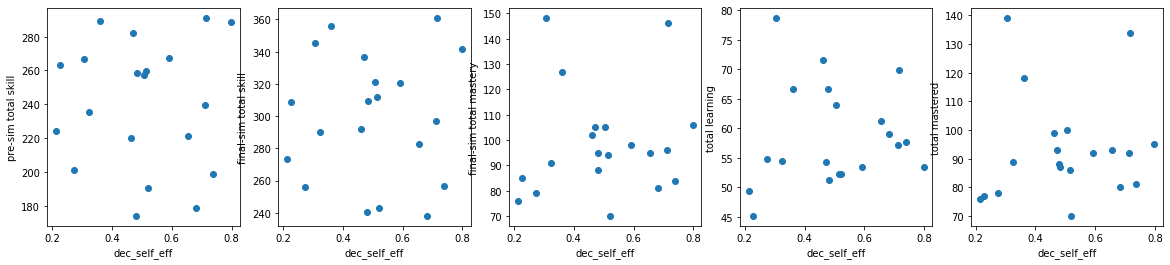

In [106]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

# Reliability Analysis

## Setup

In [53]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [54]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [55]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [56]:
def calc_split_half_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)

    # Split tx by random half sessions
    idx = tx.loc[:, ['stu_id', 'session_id']].drop_duplicates()
    idx['split_half'] = idx.groupby('stu_id')['session_id'].apply(rand_split)
    # Index tx by split half
    tx = pd.merge(tx, idx, on=['stu_id', 'session_id'], how='inner')
    
    # Get step rollup
    steps = tx.groupby('split_half').apply(step_calc.rollup_tx).reset_index()
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = tx.groupby('split_half').apply(calc.calc_detected_offtask).unstack().rename('detect_offtask')
    detect_guess = tx.groupby('split_half').apply(calc.calc_detected_guess).unstack().rename('detect_guess')
    time_on_task = tx.groupby('split_half').apply(calc.calc_time_on_task)
    time_on_task.index = time_on_task.index.swaplevel()

    # Count opportunities at each knowledge level
    kc_prac = steps.groupby('split_half').apply(step_calc.count_practice_challenge)
    kc_prac.index = kc_prac.index.swaplevel()
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
    kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = steps.groupby('split_half').apply(calc_step_accuracy).unstack().rename('accuracy')

    # Calculate work rate:
    work_rate = steps.groupby('split_half').apply(calc.calc_avg_work_rate).unstack().rename('work rate')
    exp_work_rate = steps.groupby('split_half').apply(calc_expected_work_rate).unstack().rename('exp_work_rate')

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'split_half', 'knowledge_level'])['Hint'].mean().unstack(level=2)
    stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = tx.groupby('split_half').apply(get_action_counts)
    action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = tx.groupby('split_half').apply(total_tx_stats)
    tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = tx.groupby('split_half').apply(calc_stu_session_stats)
    ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats#, action_dist, tx_stats, ses_stats
    

In [57]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

## Calculate Split-half Reliability

In [58]:
ses_calc = SessionCalculator(db)

In [59]:
split_stu_stats = {desc: {} for desc in batch_descs}
batch_size=2
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"Calculating split-half reliability of {len(sid)} students for batch, {desc}")
    
    
    def calc_split_stats(sids):
        d = calc_split_half_stats(sids)
        d.index.rename("stu_id", level=0, inplace=True)
        d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

        logger.info("Completed calculated and merging reliability stats: {split_stu_stats.shape}")
        return result
    
    args = [calc_split_stats, ids, batch_size]
    split_stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student split half stats: {split_stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Calculating split-half reliability of 20 students for batch, Self-Efficacy students
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
INFO:analytics.session:Completed calculated and merging reliability stats: {split_stu_stats.shape}
IN

## Compare Reliability of estimators

### Align direction of measures and scale

In [60]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = split_stu_stats[desc]
    for m in measures:
        d = ss[m]
        split_stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

INFO:analytics.session:Aligning columns for student sim: Self-Efficacy students
INFO:analytics.session:Added new columns: dict_values(['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish'])


In [61]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1}
for desc in batch_descs:
    ss = split_stu_stats[desc].unstack(level=1)
    # Calculate reliability of each measu
    for m in measures:
        logger.info(f"Calculating alpha for factors: {m}")
        alpha = CronbachAlpha(ss[m])    
        logger.info(f"Alpha: {alpha}")
        corr, pval = pearsonr(ss[m][0],ss[m][1])
        logger.info(f"Reliability: {abs(corr)}")

INFO:analytics.session:Calculating alpha for factors: pct class
INFO:analytics.session:Alpha: 0.6047065623720131
INFO:analytics.session:Reliability: 0.4342033706751982
INFO:analytics.session:Calculating alpha for factors: Pct OffTask
INFO:analytics.session:Alpha: 0.507582402388564
INFO:analytics.session:Reliability: 0.3531166228361925
INFO:analytics.session:Calculating alpha for factors: start speed
INFO:analytics.session:Alpha: 0.5754791263018688
INFO:analytics.session:Reliability: 0.4117549310265362
INFO:analytics.session:Calculating alpha for factors: early finish
INFO:analytics.session:Alpha: 0.4150610206664962
INFO:analytics.session:Reliability: 0.2852912060370882


In [62]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
dil_factors = [f"align {f}" for f in dil_factors]

n = len(batch_descs)
# plt.figure(figsize=(5*n,4))
logger.info(f"Calculating Cronbachs for factor with measures: {dil_factors}")
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = split_stu_stats[desc]
#    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

    xcols = dil_factors
    ycol = "diligence"
    vals = []
    #Factor analysis
    for i in range(2):
        logger.info(f"Calculating factor for split_half: {i}")
        df = ss.loc[(slice(None),i),xcols]
        kmo_all, kmo_model = calculate_kmo(df)
#         logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
        fa = FactorAnalyzer(rotation=None,  n_factors=1)
        fa.fit(df)
        # Check Eigenvalues
        ev, v = fa.get_eigenvalues()
#         logger.info(f"EigenValues: {ev}")
#         logger.info(f"Factor Loadings: {fa.loadings_}")
#         logger.info(f"Factor Variance: {fa.get_factor_variance()}")

        loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
#         logger.info(f"Factor loadings: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1).reset_index(name=i)
        vals.append(X.drop(columns=[col for col in X.columns if col == 'split_half']))
        logger.info(X.shape)
        Y = ss.loc[(slice(None), i),ycol]
#         corr, pval = pearsonr(X,Y)
#         logger.info("******************* Pearson ********************")
#         logger.info(f"R = {corr}\t pval = {pval}")
    X = pd.merge(vals[0], vals[1], on=['stu_id'], how='outer')
    X.index = X['stu_id']
    X.drop(columns=[col for col in X.columns if type(col) != int], inplace=True)
    corr, pval = pearsonr(X[0],X[1])
    logger.info(f"Reliability: {abs(corr)}")
    alpha = CronbachAlpha(X)    
    logger.info(f"Alpha: {alpha}")
    
#     plt.subplot(1,n,i+1)
#     plt.scatter(X, Y)
#     plt.title(desc)
#     plt.xlabel("estimated diligence")
#     plt.ylabel(ycol)
# plt.show()

INFO:analytics.session:Calculating Cronbachs for factor with measures: ['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish']
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Calculating factor for split_half: 0
INFO:analytics.session:(20, 3)
INFO:analytics.session:Calculating factor for split_half: 1
INFO:analytics.session:(20, 3)
INFO:analytics.session:Reliability: 0.5049755485010815
INFO:analytics.session:Alpha: 0.6681433996375366
